## Importing Libraries

## Preparing Data 

In [1]:
import numpy as np 
import pandas as pd
import os 
from skimage import io 
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf 
import cv2
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import plotly.express as px
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.applications.vgg16 import VGG16
import json
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings("ignore")

In [2]:
PATH ='/kaggle/input/lgg-mri-segmentation/kaggle_3m/'
data=pd.read_csv(PATH+'data.csv')
data

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,TCGA_HT_8563,2.0,5.0,3,1.0,NaN,2.0,2,1.0,2.0,1.0,3.0,2.0,1.0,30.0,3.0,2.0,0.0
106,TCGA_HT_A5RC,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,1.0,2.0,1.0,70.0,3.0,2.0,1.0
107,TCGA_HT_A616,NaN,5.0,2,1.0,NaN,2.0,1,1.0,1.0,1.0,1.0,2.0,1.0,36.0,3.0,2.0,0.0
108,TCGA_HT_A61A,NaN,5.0,2,NaN,NaN,NaN,1,3.0,1.0,1.0,1.0,6.0,1.0,20.0,3.0,2.0,0.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [4]:
image_ids=next(os.walk(PATH))[1]
X=[]
for id_ in tqdm(image_ids):
    for filename in os.listdir(PATH+id_):
            mask_path = PATH +id_+'/'+ filename
            X.extend([PATH+id_, mask_path])   

100%|██████████| 110/110 [00:00<00:00, 113.71it/s]


In [5]:
filenames=[i.split('/')[-1] for i in X[0::2]]
image_paths=X[1::2]
df=pd.DataFrame({'patient_id':filenames,'image_path':image_paths})
image=df[~df['image_path'].str.contains('mask')]
mask=df[df['image_path'].str.contains('mask')]
mask,image 

(                 patient_id                                         image_path
 1     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 7     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 8     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 9     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 11    TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 ...                     ...                                                ...
 7846  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 7851  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 7853  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 7855  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 7857  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 
 [3929 rows x 2 columns],
            

In [6]:
image = sorted(image['image_path'].values, key=lambda x :int(x.replace('_','0')[-15:-4]))
mask  = sorted(mask['image_path'].values, key=lambda x : int(x.replace('_','0')[-20:-9]))
image,mask

(['/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_1.tif',
  '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_2.tif',
  '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_3.tif',
  '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_4.tif',
  '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_5.tif',
  '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_6.tif',
  '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_7.tif',
  '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_8.tif',
  '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_9.tif',
  '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_1.tif',


In [7]:
mri = pd.DataFrame({'image_path':image ,"mask_path":mask })
def get_diagnosis(img_path):
    img = io.imread(img_path)
    value = np.max(img)
    if value > 0:
        return 1
    else:
        return 0
mri["mask"]=mri["mask_path"].apply(lambda x :get_diagnosis(x) )
mri

,image_path,mask_path,mask
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
...,...,...,...
3924,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3925,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3926,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3927,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


## Exploratory Data Analysis

In [8]:
# Cheking for the balance of the data
diagnosis_count = mri["mask"].value_counts()
diagnosis_percentage = (diagnosis_count / diagnosis_count.sum()) * 100
fig = px.bar(
    x=diagnosis_count.index.tolist(),
    y=diagnosis_count.values,
    color=["Negative", "Possitive"],
    labels={"x": "Diagnosis", "y": "Count", "color": "Diagnosis"},
    title="Brain Tumor Distribution",
    text=[f"{percentage:.2f}%" for percentage in diagnosis_percentage],
    height=400,
    width=600
)

fig.show()

# Data Preprocessing

In [9]:
# def train_data_generator(data_frame, batch_size, augmentations_dict,
#                          image_color_mode="rgb",
#                          mask_color_mode="grayscale",
#                          image_save_prefix="image",
#                          mask_save_prefix="mask",
#                          save_to_dir=None,
#                          target_size=(256,256),
#                          seed=1):

#     image_data_generator = ImageDataGenerator(**augmentations_dict)
#     mask_data_generator = ImageDataGenerator(**augmentations_dict)
    
#     image_generator = image_data_generator.flow_from_dataframe(
#         data_frame,
#         x_col="image_path",
#         class_mode=None,
#         color_mode=image_color_mode,
#         target_size=target_size,
#         batch_size=batch_size,
#         save_to_dir=save_to_dir,
#         save_prefix=image_save_prefix,
#         seed=seed)

#     mask_generator = mask_data_generator.flow_from_dataframe(
#         data_frame,
#         x_col="mask_path",
#         class_mode=None,
#         color_mode=mask_color_mode,
#         target_size=target_size,
#         batch_size=batch_size,
#         save_to_dir=save_to_dir,
#         save_prefix=mask_save_prefix,
#         seed=seed)

#     train_gen = zip(image_generator, mask_generator)
    
#     for (image, mask) in train_gen:
#         image, mask = adjust_data(image, mask)
#         yield (image, mask)

In [10]:
def adjust_data(img, mask):
    # Convert pixel values to floats between 0 and 1
    img = img.astype('float32') / 255.0
    mask = mask.astype('float32') / 255.0
    
    # Apply binary threshold to the mask
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return img, mask

In [11]:
train_data_seg, test_data_seg = train_test_split(mri[["image_path","mask_path"]],test_size = 0.1)
train_data_seg,val_data_seg = train_test_split(mri[["image_path","mask_path"]],test_size = 0.2)
print('train_data:',train_data_seg.shape)
print('test_data:',test_data_seg.shape)
print('val_data:',val_data_seg.shape)

train_data: (3143, 2)
test_data: (393, 2)
val_data: (786, 2)


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
def train_data_generator(data_frame, batch_size,
                         image_color_mode="rgb",
                         mask_color_mode="grayscale",
                         image_save_prefix="image",
                         mask_save_prefix="mask",
                         save_to_dir=None,
                         target_size=(256,256),
                         seed=1):

    image_data_generator = ImageDataGenerator()
    mask_data_generator = ImageDataGenerator()
    
    image_generator = image_data_generator.flow_from_dataframe(
        data_frame,
        x_col="image_path",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed)

    mask_generator = mask_data_generator.flow_from_dataframe(
        data_frame,
        x_col="mask_path",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (image, mask) in train_gen:
        image, mask = adjust_data(image, mask)
        yield (image, mask)


In [14]:
train_gen_seg = train_data_generator(train_data_seg, 32)
    
val_gen_seg = train_data_generator(val_data_seg, 32)


## Images Visualization

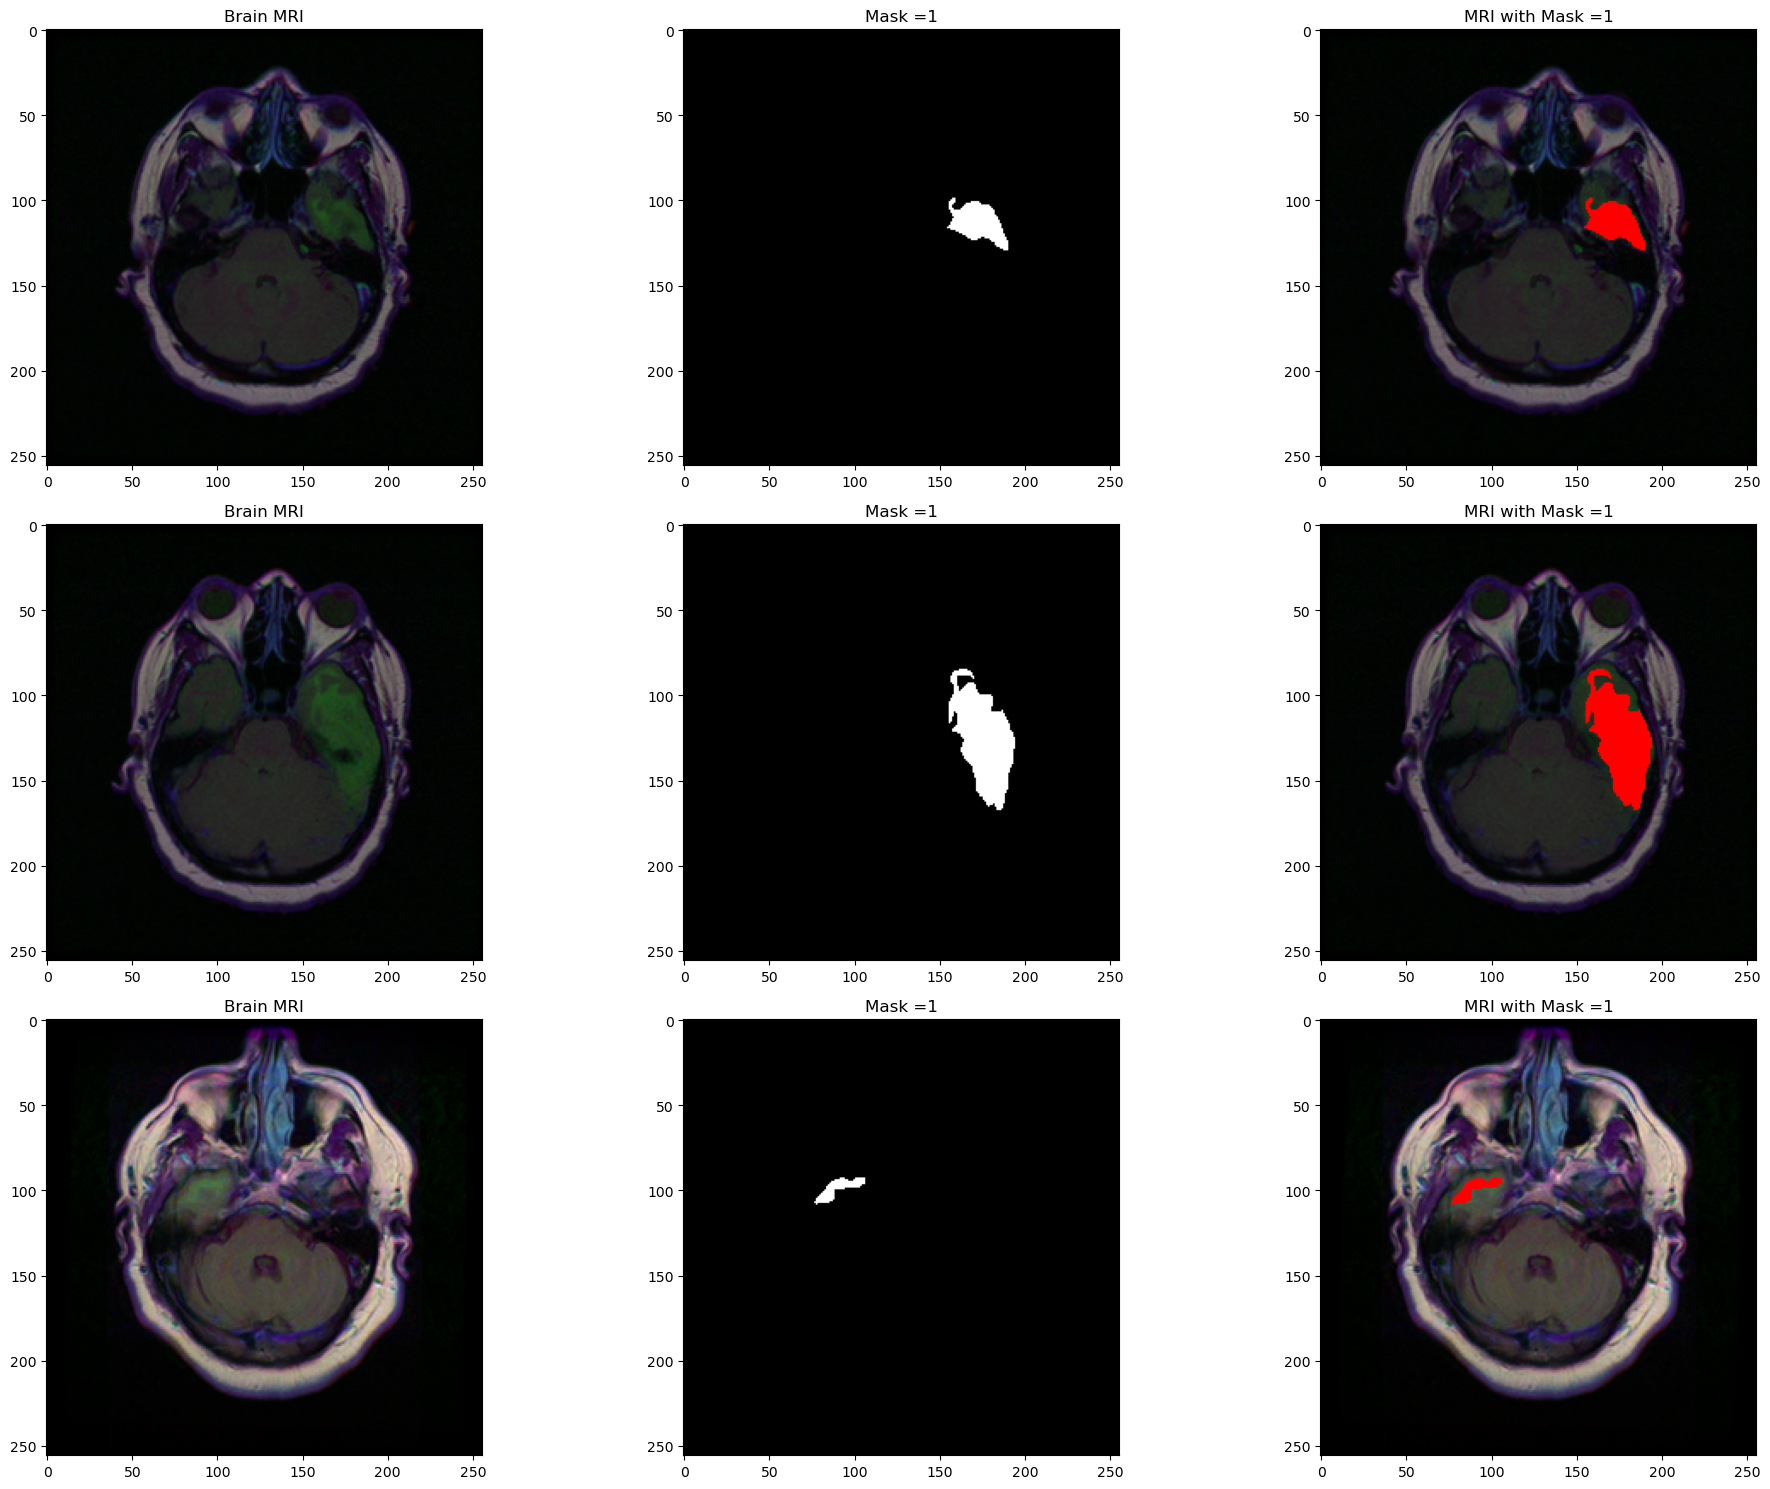

In [15]:
count = 0
i = 0
fig, axs = plt.subplots(3, 3, figsize=(20, 15))

for mask_val in mri['mask']:
    if (mask_val == 1):
        img = io.imread(mri.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(mri.mask_path[i])
        axs[count][1].title.set_text("Mask =" + str(mri['mask'][i]))
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (255,0,0)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask =" + str(mri['mask'][i]))
        axs[count][2].imshow(img)
        count += 1
    i += 1
    if (count == 3):
        break
        
fig.tight_layout()

## U_Net Model architecture

58889256/58889256 [==============================] - 0s 0us/step


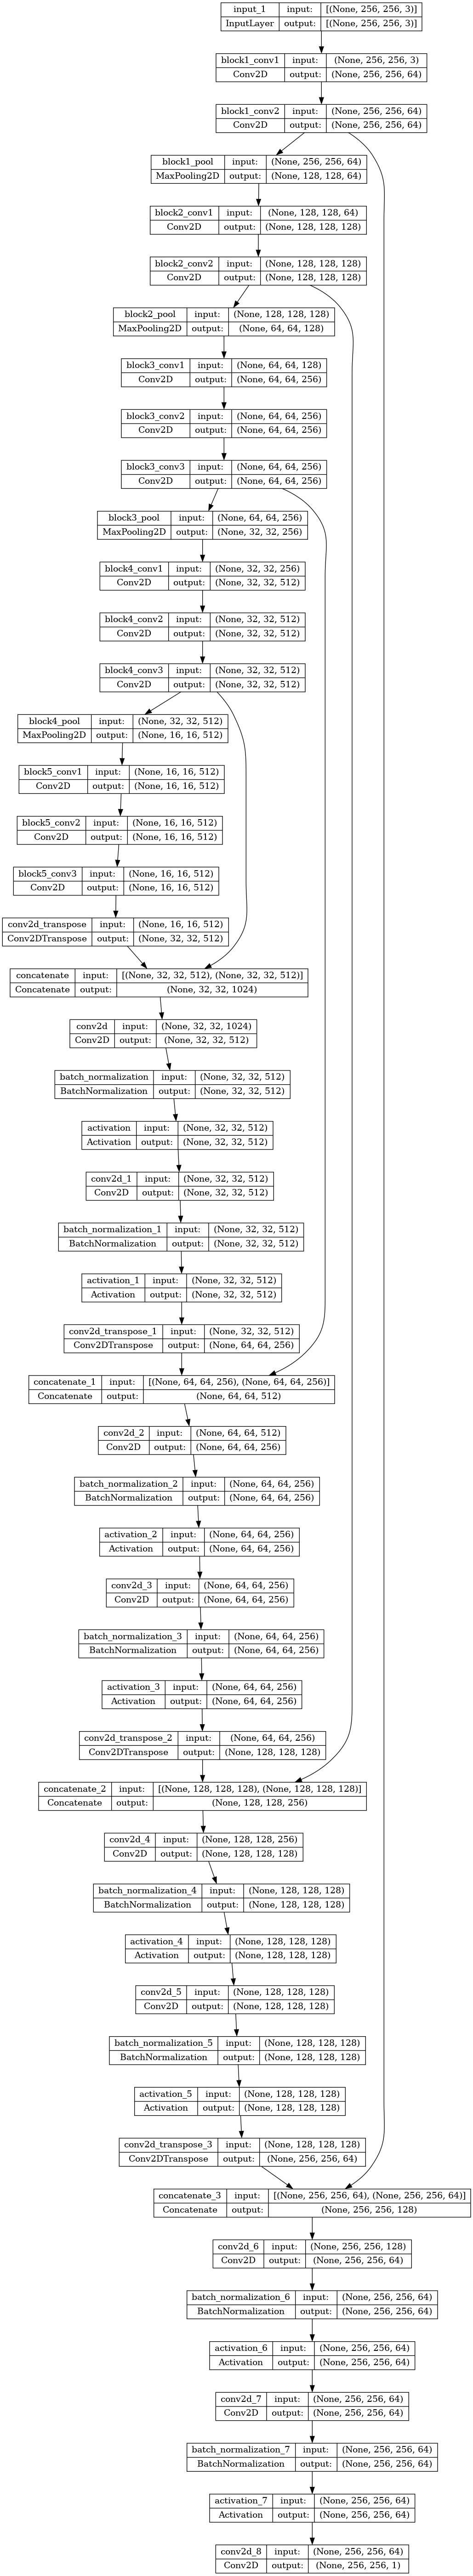

In [16]:
def build_unet_model():
    # Load the pre-trained VGG16 model
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    # Get the output from the last convolutional block of VGG16
    vgg_output = vgg16.get_layer('block5_conv3').output

    # U-Net decoder
    up1 = Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(vgg_output)
    up1 = concatenate([up1, vgg16.get_layer('block4_conv3').output], axis=3)
    conv1 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up1)
    conv1 = BatchNormalization(axis=3)(conv1)
    conv1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(conv1)
    conv1 = BatchNormalization(axis=3)(conv1)
    conv1 = Activation("relu")(conv1)

    up2 = Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(conv1)
    up2 = concatenate([up2, vgg16.get_layer('block3_conv3').output], axis=3)
    conv2 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up2)
    conv2 = BatchNormalization(axis=3)(conv2)
    conv2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(conv2)
    conv2 = BatchNormalization(axis=3)(conv2)
    conv2 = Activation("relu")(conv2)

    up3 = Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(conv2)
    up3 = concatenate([up3, vgg16.get_layer('block2_conv2').output], axis=3)
    conv3 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up3)
    conv3 = BatchNormalization(axis=3)(conv3)
    conv3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(conv3)
    conv3 = BatchNormalization(axis=3)(conv3)
    conv3 = Activation("relu")(conv3)

    up4 = Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(conv3)
    up4 = concatenate([up4, vgg16.get_layer('block1_conv2').output], axis=3)
    conv4 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up4)
    conv4 = BatchNormalization(axis=3)(conv4)
    conv4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(conv4)
    conv4 = BatchNormalization(axis=3)(conv4)
    conv4 = Activation("relu")(conv4)
    
    conv4 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(conv4)
    return Model(inputs=vgg16.input, outputs= conv4)
model = build_unet_model()   
display(tf.keras.utils.plot_model(model, to_file='u_net.png', show_shapes=True))

 # Callbacks

In [17]:
lr_reduction = ReduceLROnPlateau(monitor='val_iou',patience=8, verbose=1,
                                 factor=0.4, min_lr=0.0001)

model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', verbose=1,monitor='val_iou',
                                   save_best_only=True)
callbacks=[model_checkpoint,lr_reduction ]

## defining Metrics 'intersection over union'

In [18]:
def iou(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

## Fitting the modle

# helper functions

In [19]:
smooth =100
def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=dice_coef_loss, 
    metrics=[iou]
)


In [21]:
EPOCH = 66
history =model.fit_generator(train_gen_seg,steps_per_epoch=len(train_data_seg)//32,
                    epochs=EPOCH ,validation_data=val_gen_seg,validation_steps=len(val_data_seg) // 32,
                    callbacks=[model_checkpoint])


Found 3143 validated image filenames.
Found 3143 validated image filenames.
Epoch 1/66
98/98 [==============================] - ETA: 0s - loss: 0.7326 - iou: 0.1646Found 786 validated image filenames.
Found 786 validated image filenames.

Epoch 1: val_iou improved from inf to 0.01159, saving model to unet_membrane.hdf5
98/98 [==============================] - 106s 833ms/step - loss: 0.7326 - iou: 0.1646 - val_loss: 0.9773 - val_iou: 0.0116
Epoch 2/66
98/98 [==============================] - ETA: 0s - loss: 0.4729 - iou: 0.3667
Epoch 2: val_iou did not improve from 0.01159
98/98 [==============================] - 84s 841ms/step - loss: 0.4729 - iou: 0.3667 - val_loss: 0.9673 - val_iou: 0.0188
Epoch 3/66
98/98 [==============================] - ETA: 0s - loss: 0.3826 - iou: 0.4561
Epoch 3: val_iou did not improve from 0.01159
98/98 [==============================] - 82s 836ms/step - loss: 0.3826 - iou: 0.4561 - val_loss: 0.4917 - val_iou: 0.3504
Epoch 4/66
98/98 [========================

In [22]:
# Create directory to save model
!mkdir -p saved_model

# Save model in HDF5 file format
model.save('saved_model/my_model.h5')

# Save model architecture in JSON format
model_architecture = model.to_json()
with open('UNet-seg-model.json', 'w') as f:
    f.write(model_architecture)


## train_history

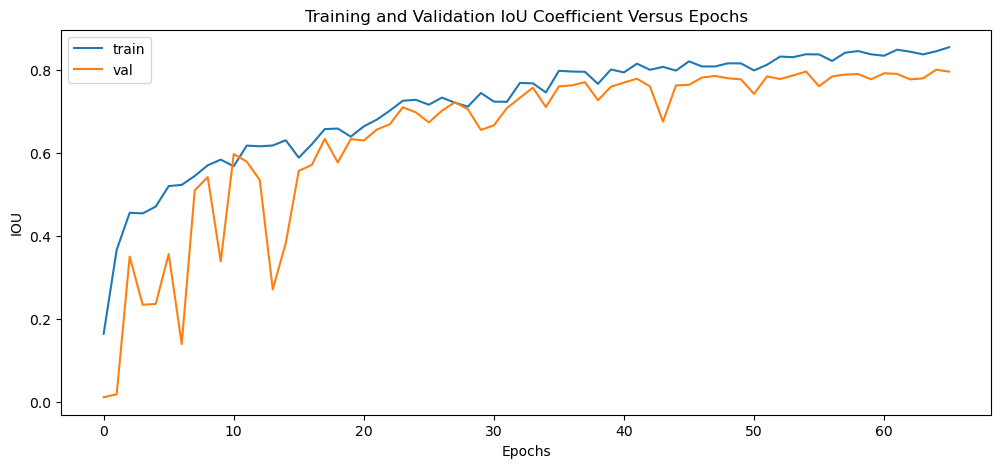

In [23]:
plt.figure(figsize=(12,5))
plt.plot(history.history['iou'])
plt.plot(history.history['val_iou'])
plt.title('Training and Validation IoU Coefficient Versus Epochs')
plt.ylabel("IOU")
plt.xlabel("Epochs")
plt.legend(['train', 'val'])
plt.show()

# test_Evaluation

In [24]:
test_gen_seg=train_data_generator(test_data_seg, 32)

In [25]:
_, iou_metric = model.evaluate_generator(test_gen_seg, steps=len(test_data_seg)//32)
print("dice_coff_loss: %.2f%%:"%(_*100))
print("iou : %.2f%%"% (iou_metric*100))

Found 393 validated image filenames.
Found 393 validated image filenames.
dice_coff_loss: 8.11%:
iou : 85.08%


## Prediction

In [26]:
def predict_masks(test_set, model):

    # Create empty lists to store the results
    masks = []
    img_paths = []
    has_masks = []
    
    for path in test_data_seg['image_path']:
        
        # Load the image
        img = io.imread(path)
        
        # Resize the image
        img = cv2.resize(img, (256,256))
        
        # Standardize the image
        img = (img - np.mean(img)) / np.std(img)
        
        # Add batch dimension
        img = np.expand_dims(img, axis=0)
        
        # Make predictions
        pred_mask = model.predict(img)
        
        # If the sum of predicted mask is 0 then there is no tumor
        if pred_mask.round().astype(int).sum() == 0:
            img_paths.append(path)
            has_masks.append(0)
            masks.append('No mask')
        else:
            # If the sum of pixel values is more than 0, then there is tumor
            img_paths.append(path)
            has_masks.append(1)
            masks.append(pred_mask[0])
            
    # Create a pandas dataframe with the results
    results_df = pd.DataFrame({'image_path': img_paths, 'predicted_mask': masks, 'has_mask': has_masks})
    
    return results_df


In [27]:
prediction = predict_masks(test_data_seg, model)
prediction

1/1 [==============================] - 0s 21ms/step


,image_path,predicted_mask,has_mask
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask,0
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask,0
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,"[[[8.063104e-09], [7.0841515e-13], [7.975997e-...",1
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask,0
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask,0
...,...,...,...
388,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask,0
389,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask,0
390,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask,0
391,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask,0


In [28]:
prediction= test_data_seg.merge(prediction, on='image_path')
prediction.head()

,image_path,mask_path,predicted_mask,has_mask
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask,0
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask,0
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,"[[[8.063104e-09], [7.0841515e-13], [7.975997e-...",1
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask,0
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask,0


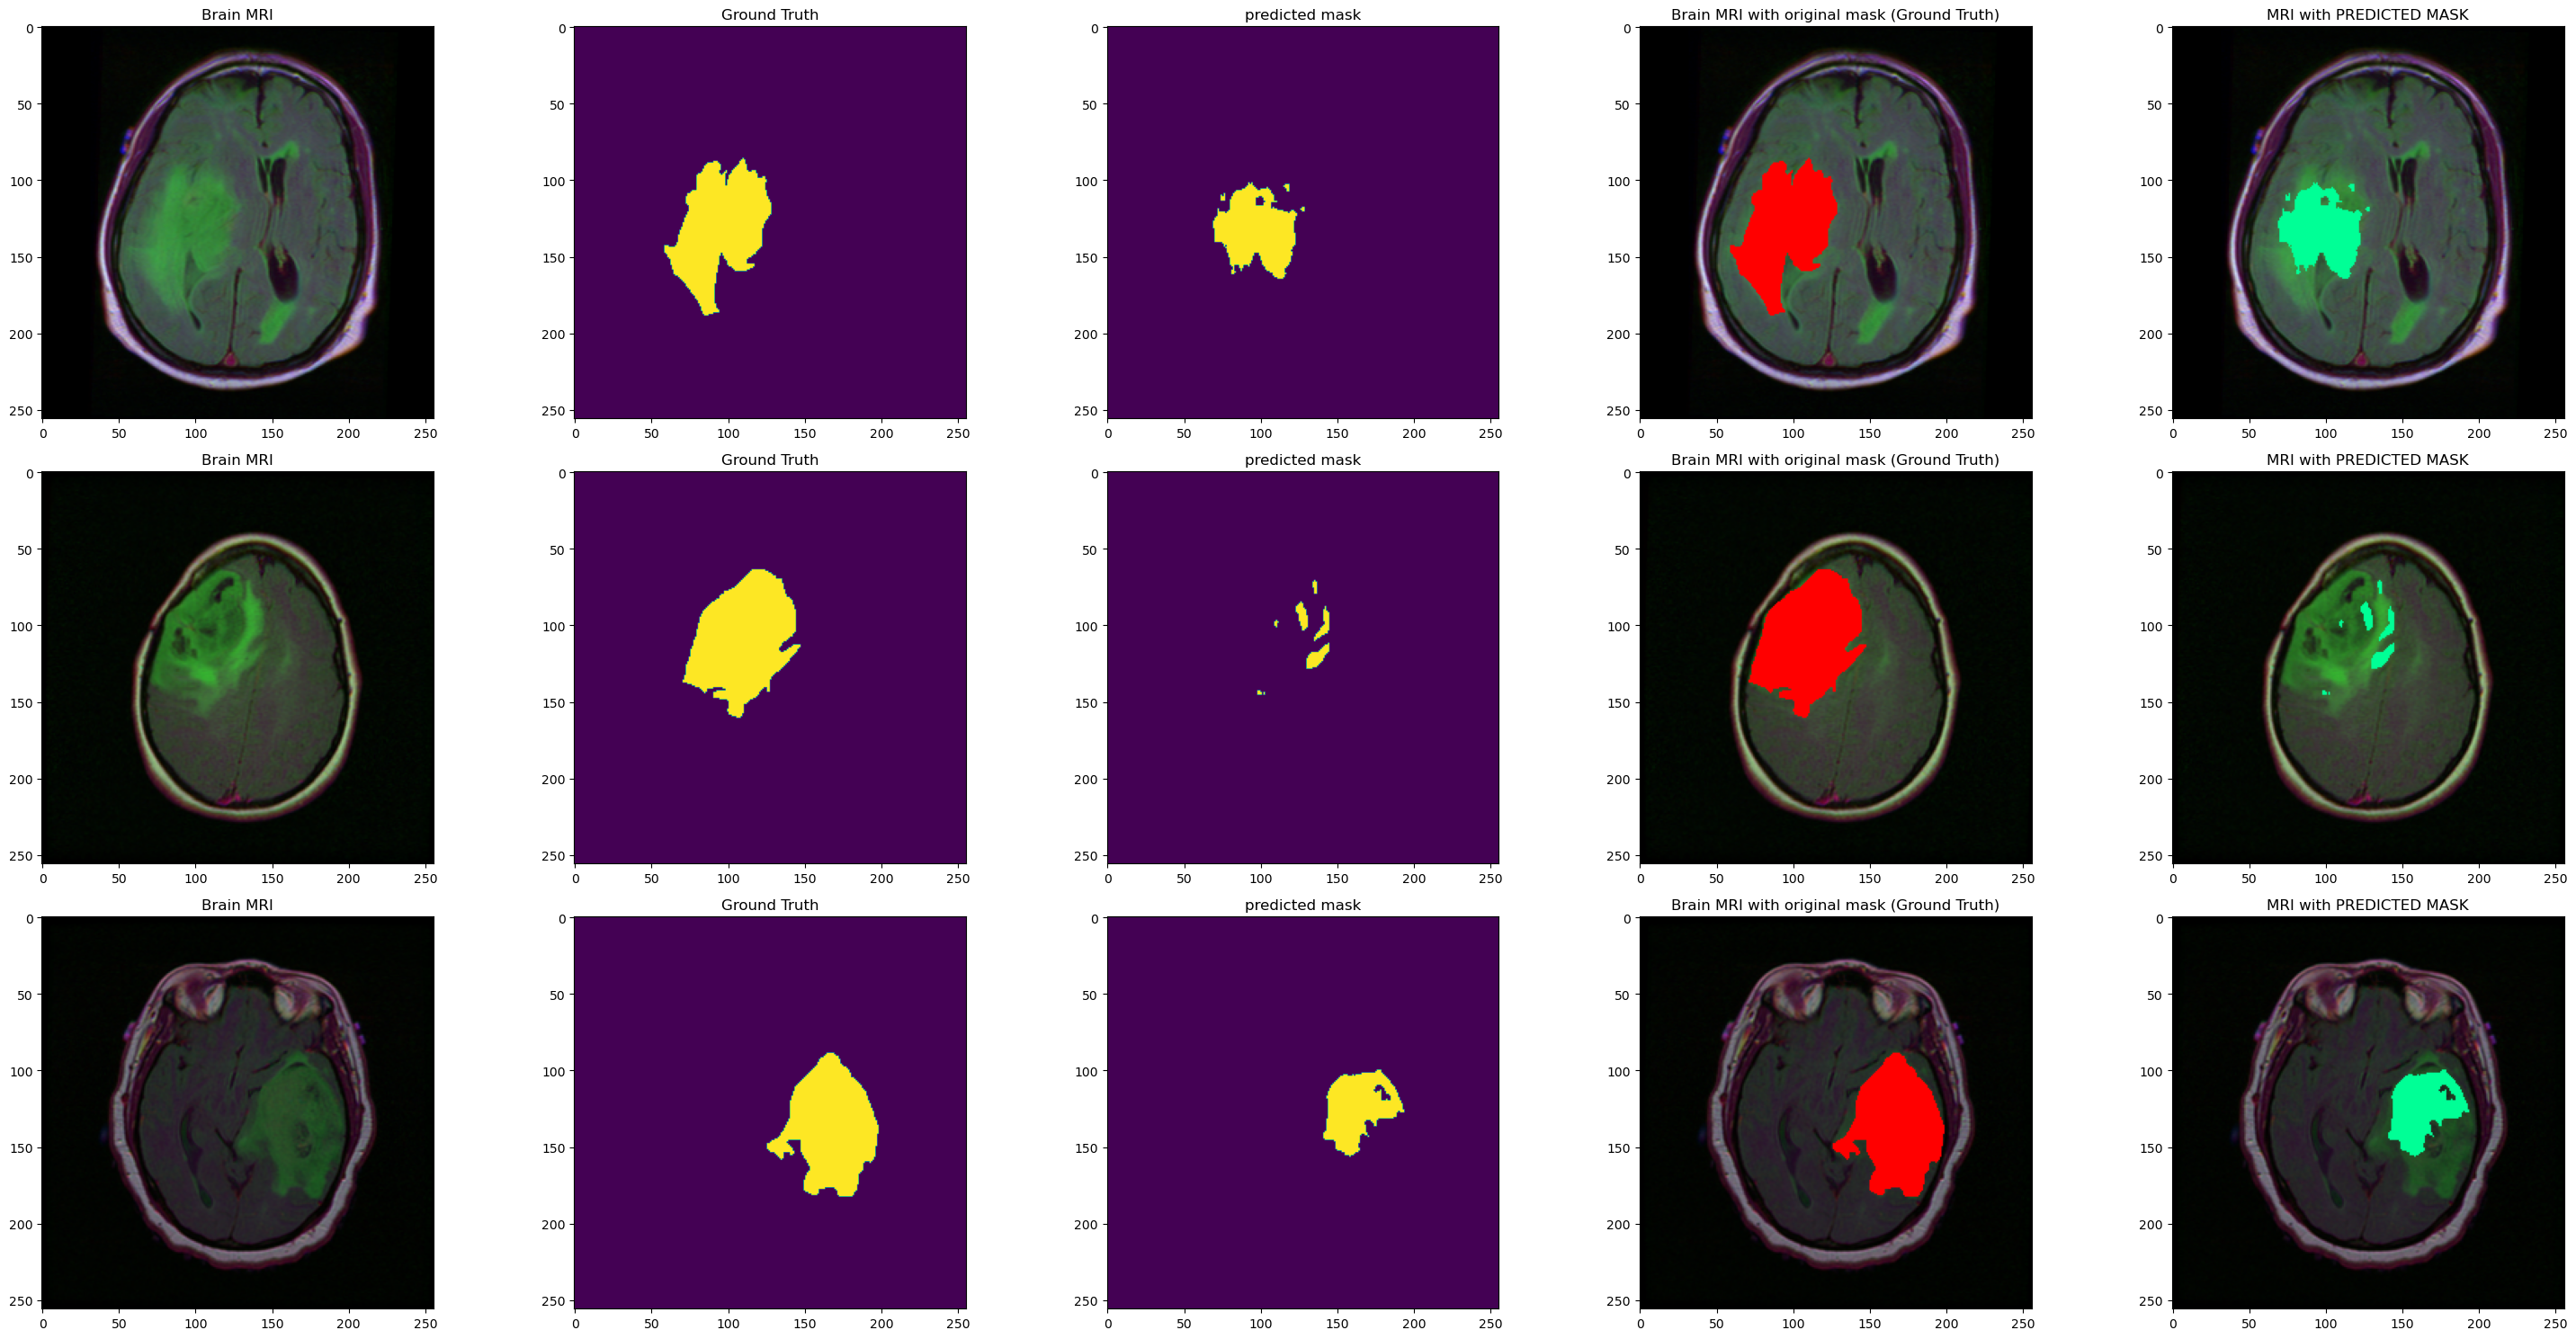

In [29]:
count = 0
fig, axs = plt.subplots(3,5, figsize=(30,15))

for i in range(len(prediction)):
    if prediction.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(prediction.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        
        #read original mask
        mask = io.imread(prediction.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Ground Truth')
        
        #read predicted mask
        pred = np.array(prediction.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('predicted mask')
        
        #overlay original mask with MRI
        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')
        
        #overlay predicted mask and MRI
        img_ = io.imread(prediction.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with PREDICTED MASK')
        count +=1
    if (count==3):
        break

fig.tight_layout()